In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import swifter
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


# Project Objective: 
## &emsp;Create a model that can predict the price of an airbnb unit based on the time of year and listing characteristics.

# Notebook Objective: 
## &emsp;Engineer location-based features.  These include Features that indicate the listing proximity to the ocean or whether or not they are located in a resort area.

In [3]:
df=pd.read_csv('airbnbHawaii_cleaned3.csv')
df.head()

,listing_id,price,neighbourhood_cleansed,latitude,longitude,property_type,accommodates,bathrooms,bedrooms,review_scores_location,...,isHoliday,isNew,time,listing_url,missing_rating,number_of_reviews,hasPool,hasHotTub,property_group,log_price
0,5269,136.500000,South Kohala,20.0274,-155.702,Entire rental unit,2,1.0,1.0,5.0,...,False,False,0,https://www.airbnb.com/rooms/5269,False,28,False,False,propertyGroup6,4.923624
1,5269,140.000000,South Kohala,20.0274,-155.702,Entire rental unit,2,1.0,1.0,5.0,...,False,False,1,https://www.airbnb.com/rooms/5269,False,28,False,False,propertyGroup6,4.948760
2,5269,141.428571,South Kohala,20.0274,-155.702,Entire rental unit,2,1.0,1.0,5.0,...,False,False,2,https://www.airbnb.com/rooms/5269,False,28,False,False,propertyGroup6,4.958841
3,5269,145.000000,South Kohala,20.0274,-155.702,Entire rental unit,2,1.0,1.0,5.0,...,False,False,3,https://www.airbnb.com/rooms/5269,False,28,False,False,propertyGroup6,4.983607
4,5269,145.000000,South Kohala,20.0274,-155.702,Entire rental unit,2,1.0,1.0,5.0,...,False,False,4,https://www.airbnb.com/rooms/5269,False,28,False,False,propertyGroup6,4.983607


**Hawaiian_Cost.geojson was created at geojson.io.  The file contains a line string representing the west hawaian coast.  This data will be used to extract a feature specifiying the distance to the ocean for each listing**

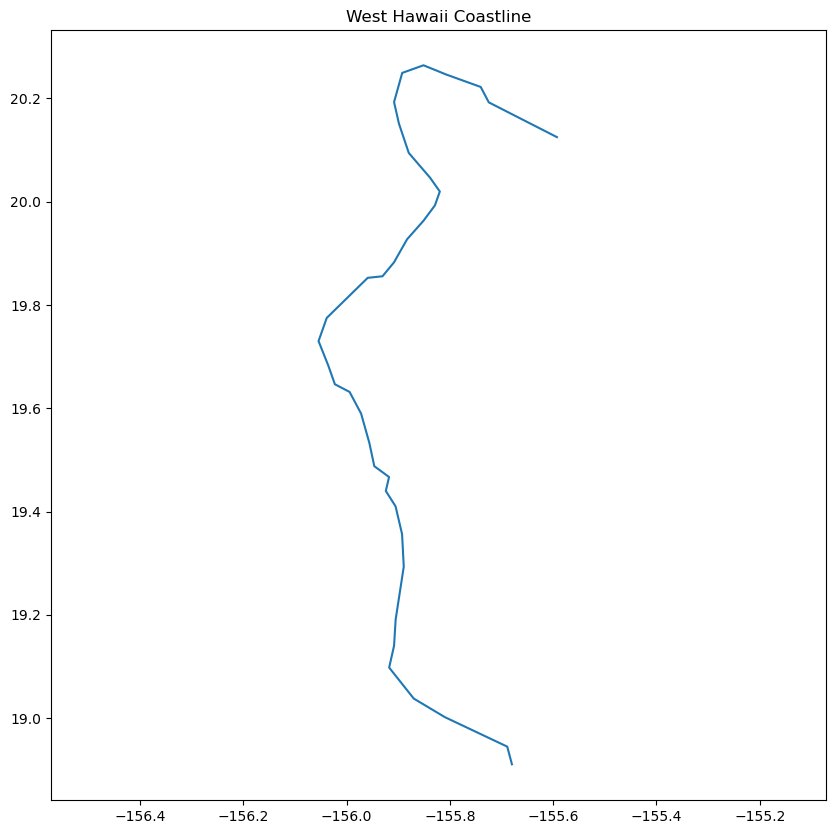

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the GeoJSON file
west_hawaii_coast = gpd.read_file('Hawaiian_Coast.geojson')

# Plot the linestrings
fig, ax = plt.subplots(figsize=(10, 10))
west_hawaii_coast.plot(ax=ax)
ax.set_title('West Hawaii Coastline')
plt.axis('equal')
plt.show()

# Compute distance to ocean.

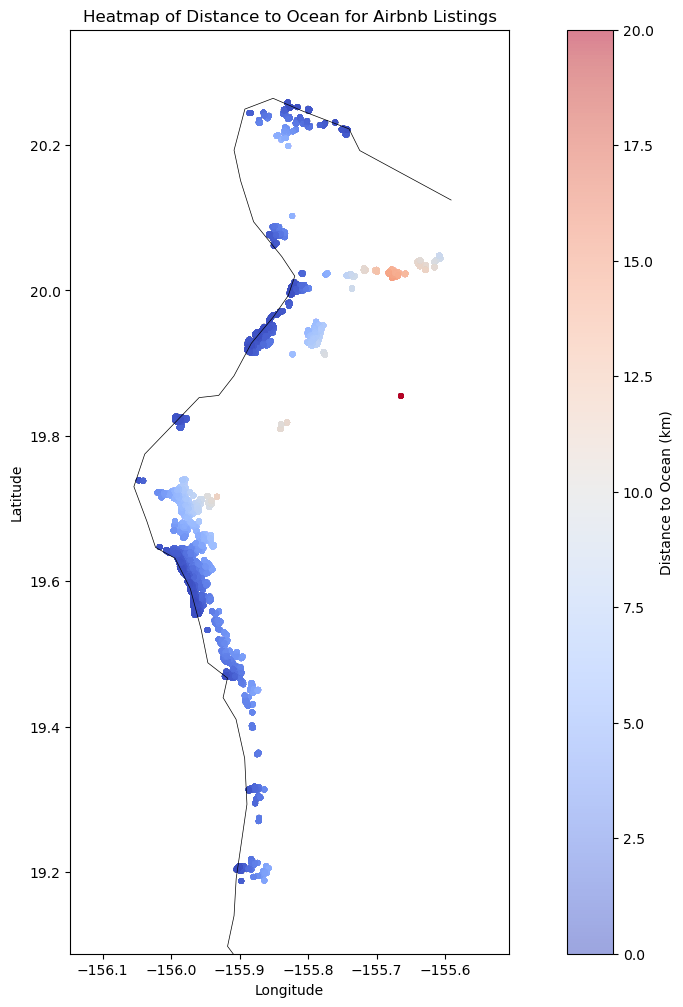

In [8]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.ops import nearest_points


gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")


gdf = gdf.to_crs("EPSG:32604")
west_hawaii_coast = west_hawaii_coast.to_crs("EPSG:32604")


def calculate_distance_to_ocean(point, coastline):
    nearest_point = nearest_points(point, coastline.unary_union)[1]
    return point.distance(nearest_point)


gdf['distanceToOcean'] = gdf.geometry.apply(calculate_distance_to_ocean, coastline=west_hawaii_coast)

# Convert distance to kilometers
gdf['distanceToOcean'] = gdf['distanceToOcean'] / 1000

# Convert back to original CRS for plotting
gdf = gdf.to_crs("EPSG:4326")
west_hawaii_coast = west_hawaii_coast.to_crs("EPSG:4326")


plt.figure(figsize=(15, 12))
scatter = plt.scatter(gdf.geometry.x, gdf.geometry.y, c=gdf['distanceToOcean'], 
                      cmap='coolwarm', s=10, alpha=0.5, vmin=0, vmax=20)
plt.colorbar(scatter, label='Distance to Ocean (km)')


west_hawaii_coast.plot(ax=plt.gca(), color='black', linewidth=0.5)

plt.title('Heatmap of Distance to Ocean for Airbnb Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust the plot limits to focus on the area of interest
plt.xlim(gdf.geometry.x.min() - 0.1, gdf.geometry.x.max() + 0.1)
plt.ylim(gdf.geometry.y.min() - 0.1, gdf.geometry.y.max() + 0.1)

plt.show()


# Resort_Area Feature
**Geojson files 'mauna_kea2.geojson', 'Waikoloa:MaunaLani.geojson','Fourseasons.geojson' were created at geojson.io and contain polygons representing specific resort areas.  This data will be used to determine the listings that are in a specific resort area.**

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_1338/4082717787.py:29: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


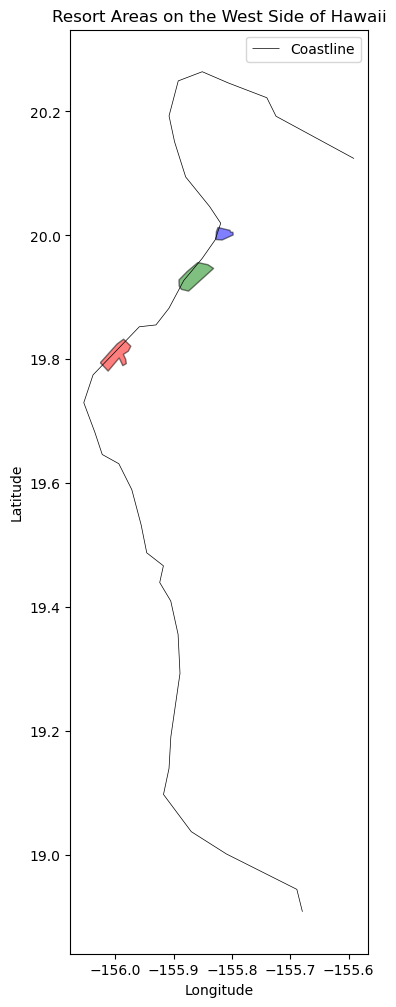

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON files
mauna_kea = gpd.read_file('mauna_kea2.geojson')
waikoloa_mauna_lani = gpd.read_file('Waikoloa:MaunaLani.geojson')
four_seasons = gpd.read_file('Fourseasons.geojson')
west_hawaii_coast = gpd.read_file('Hawaiian_Coast.geojson')

# Ensure all GeoDataFrames have the same CRS
crs = "EPSG:4326"
mauna_kea = mauna_kea.to_crs(crs)
waikoloa_mauna_lani = waikoloa_mauna_lani.to_crs(crs)
four_seasons = four_seasons.to_crs(crs)
west_hawaii_coast = west_hawaii_coast.to_crs(crs)

# Plot the data
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the coastline
west_hawaii_coast.plot(ax=ax, color='black', linewidth=0.5, label='Coastline')

# Plot the resort areas
mauna_kea.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', label='Mauna Kea')
waikoloa_mauna_lani.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label='Waikoloa/Mauna Lani')
four_seasons.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', label='Four Seasons')

# Add a legend
plt.legend()

# Add titles and labels
plt.title('Resort Areas on the West Side of Hawaii')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


gdf info:
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 346581 entries, 0 to 346580
Data columns (total 30 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   listing_id                 346581 non-null  int64   
 1   price                      346581 non-null  float64 
 2   neighbourhood_cleansed     346581 non-null  object  
 3   latitude                   346581 non-null  float64 
 4   longitude                  346581 non-null  float64 
 5   property_type              346581 non-null  object  
 6   accommodates               346581 non-null  int64   
 7   bathrooms                  346581 non-null  float64 
 8   bedrooms                   346581 non-null  float64 
 9   review_scores_location     346581 non-null  float64 
 10  review_scores_rating       346581 non-null  float64 
 11  review_scores_cleanliness  346581 non-null  float64 
 12  room_type_Private room     346581 non-null  bool    
 

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_1338/1156641994.py:70: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


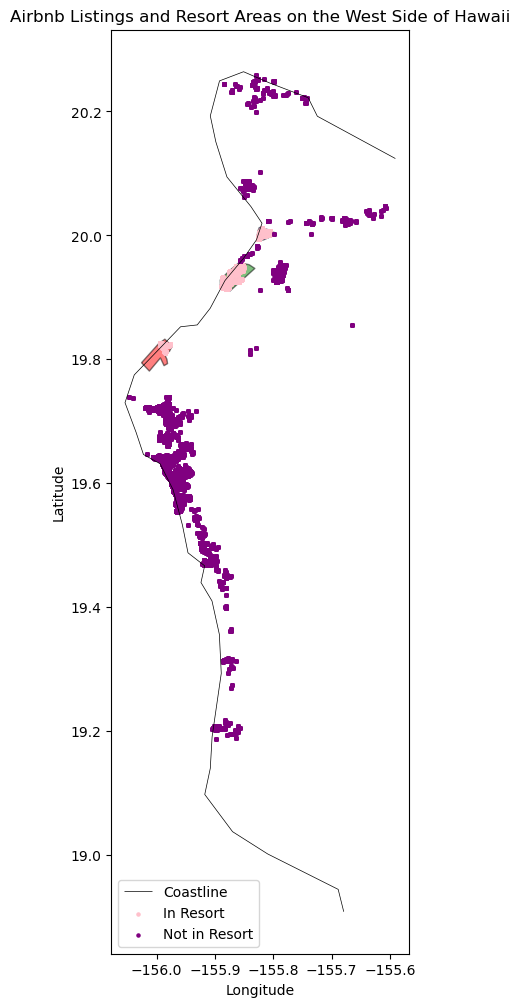

In [13]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Add a unique identifier for each resort area
mauna_kea['resort'] = 'Mauna Kea'
waikoloa_mauna_lani['resort'] = 'Mauna Lani/Waikaloa'
four_seasons['resort'] = 'Four Seasons'

# Combine all resort polygons into a single GeoDataFrame
all_resorts = gpd.GeoDataFrame(pd.concat([mauna_kea, waikoloa_mauna_lani, four_seasons], ignore_index=True))

# Ensure all GeoDataFrames have the same CRS
crs = "EPSG:4326"
all_resorts = all_resorts.to_crs(crs)
gdf = gdf.to_crs(crs)  # Ensure gdf is in the same CRS

print("gdf info:")
print(gdf.info())
print("\nall_resorts info:")
print(all_resorts.info())

print("gdf CRS:", gdf.crs)
print("all_resorts CRS:", all_resorts.crs)

try:
    joined = gpd.sjoin(gdf, all_resorts, how="left", predicate="within")
    print("Spatial join successful")
    print(joined.columns)
    
    # Create 'inResort' column
    gdf['inResort'] = joined['index_right'].notnull()
    
    # Create 'resortArea' column
    gdf['resortArea'] = joined['resort'].fillna('Not in Resort')
    
except Exception as e:
    print("Error in spatial join:", str(e))
    
    # Alternative method if spatial join fails
    def is_within_resort(point, resorts):
        for idx, row in resorts.iterrows():
            if point.within(row.geometry):
                return row['resort']
        return 'Not in Resort'

    gdf['resortArea'] = gdf.geometry.apply(lambda point: is_within_resort(point, all_resorts))
    gdf['inResort'] = gdf['resortArea'] != 'Not in Resort'

print("\nResults:")
print(gdf['inResort'].value_counts())
print(gdf['resortArea'].value_counts())

# Plotting
fig, ax = plt.subplots(figsize=(15, 12))

# Plot the coastline
if 'west_hawaii_coast' in globals():
    west_hawaii_coast.plot(ax=ax, color='black', linewidth=0.5, label='Coastline')

# Plot the resort areas
mauna_kea.plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', label='Mauna Kea')
waikoloa_mauna_lani.plot(ax=ax, color='green', alpha=0.5, edgecolor='black', label='Mauna Lani/Waikaloa')
four_seasons.plot(ax=ax, color='red', alpha=0.5, edgecolor='black', label='Four Seasons')

# Plot the Airbnb listings
gdf[gdf['inResort']].plot(ax=ax, color='pink', markersize=5, label='In Resort')
gdf[~gdf['inResort']].plot(ax=ax, color='purple', markersize=5, label='Not in Resort')

plt.legend()
plt.title('Airbnb Listings and Resort Areas on the West Side of Hawaii')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('Resorts_Listings.png')
plt.show()


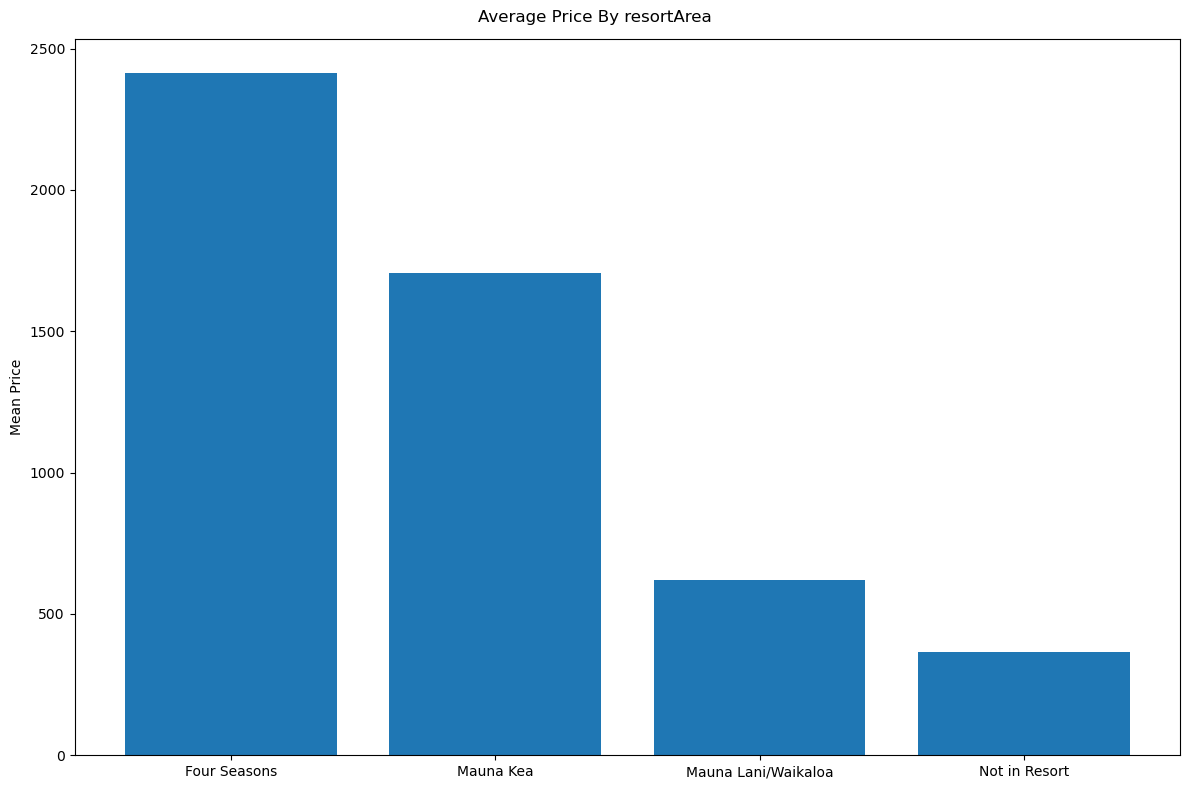

In [23]:
grouped=gdf.groupby('resortArea').agg({'price':'mean'}).reset_index()
fig, ax=plt.subplots(figsize=(12,8))
ax.bar(x='resortArea',height='price',data=grouped)
ax.set_ylabel('Mean Price')
fig.suptitle('Average Price By resortArea')
plt.tight_layout()
plt.show()

**The bar graph shows that these resorts could potentially explain differences in price.**

# Neighborhood
**Another feature that will be used is the neighborhood feature.  The csv comes with a column for the neighborhood associated with each listing.  Below I show the average prices for each neighborhood.**

/var/folders/y_/zdr3xmx13qz3pq6ct9kglm7h0000gn/T/ipykernel_1338/69411582.py:33: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, name in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged.index):


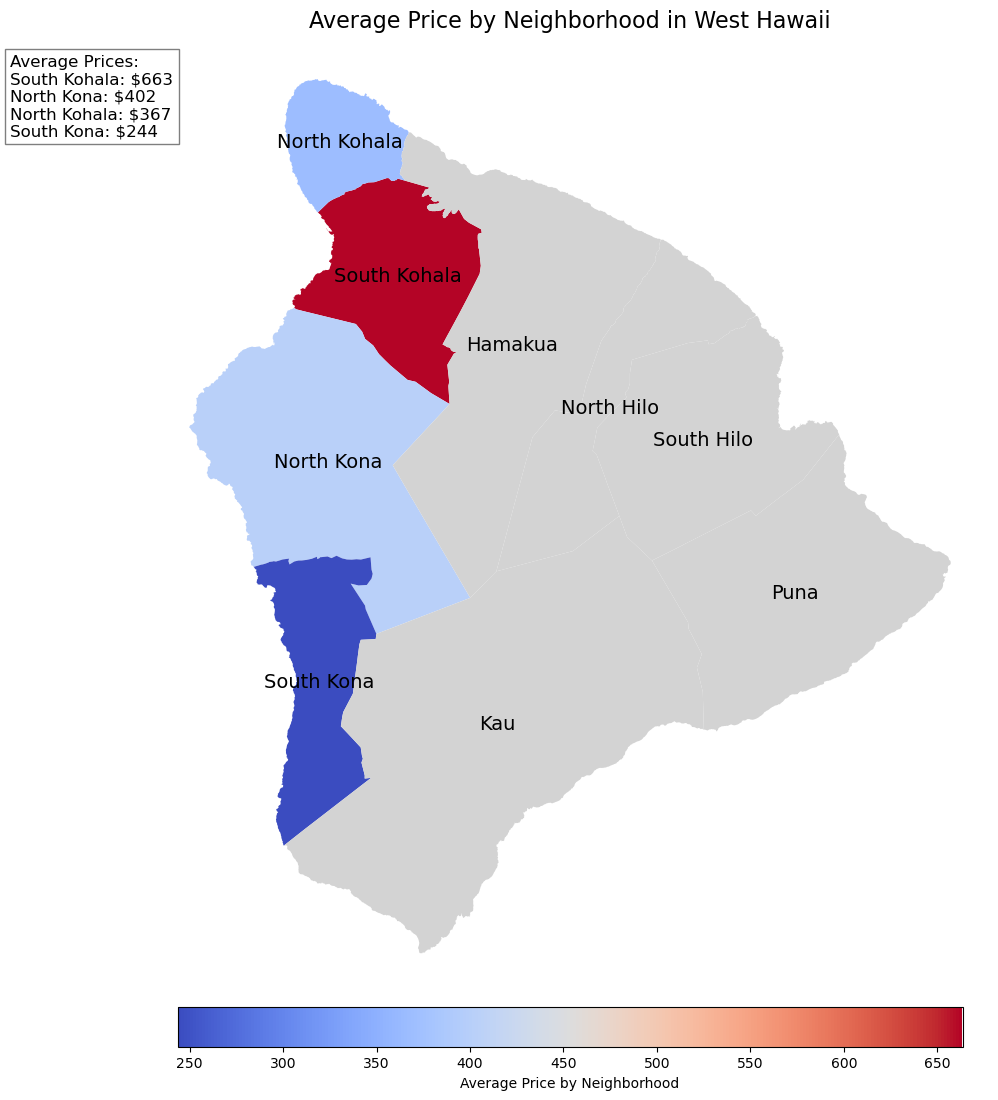

In [34]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the GeoJSON file
neighborhoods = gpd.read_file('neighbourhoods.geojson')
neighborhoods = neighborhoods[neighborhoods['neighbourhood_group'] == 'Hawaii']

# Calculate average price by neighborhood
average_price = df.groupby('neighbourhood_cleansed')['price'].mean().reset_index()

# Merge the average price data with the GeoDataFrame
merged = neighborhoods.set_index('neighbourhood').join(average_price.set_index('neighbourhood_cleansed'))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(16, 12))  # Make the plot bigger
# Plot the neighborhoods with a smaller color bar
merged.plot(column='price', ax=ax, legend=True,
            legend_kwds={'label': "Average Price by Neighborhood",
                         'orientation': "horizontal",
                         'shrink': 0.5,
                        'pad':.009},  # Shrink the color bar
            cmap='coolwarm'  ,    #'OrRd',  # Color map
            missing_kwds={"color": "lightgrey", "label": "Not Available"})

# Add title
plt.title('Average Price by Neighborhood in West Hawaii', fontsize=16)

# Hide the axes
ax.set_axis_off()

# Add text labels for neighborhood names
for x, y, name in zip(merged.geometry.centroid.x, merged.geometry.centroid.y, merged.index):
    ax.text(x, y, name, fontsize=14, ha='center', va='center', color='black')

# Optionally, display average prices in a separate area of the plot
# Create a legend for average prices
price_legend = average_price.set_index('neighbourhood_cleansed').sort_values(by='price', ascending=False)

# Display average prices in a text box at the top
plt.figtext(0.15, 0.95, 'Average Prices:\n' + '\n'.join([f"{area}: ${price:,.0f}" for area, price in zip(price_legend.index, price_legend['price'])]), 
            fontsize=12, ha='left', va='top', bbox=dict(facecolor='white', alpha=0.5))

# Show the plot
plt.tight_layout()
plt.show()

# Write to csv

In [19]:
gdf.to_csv('airbnb_project_clean5.csv')